## Main Code

In [1]:
# Game

import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import scipy.stats

class game:
    def __init__(self, size=4, rules=[1,4,-1,-2,0,0]):
        self.size = size
        self.rules = rules
        self.wallfn = np.vectorize(lambda x: max([0,x]) + min([0,self.size - 1 -x]))
        # Mutual cooperation, betrayal(win/loss), mutual betrayal.
    def start(self):
        self.A = np.zeros(2,dtype=int)
        self.B = np.array([self.size - 1, self.size - 1])
        ind = []
        for _ in range(4):
            ind.append(rnd.randint(1,self.size - 2))
        self.a = np.array([ind[0], ind[1]])
        self.b = np.array([ind[2], ind[3]])
        self.score = np.zeros(2)
    def move(self, moveA, moveB):
        direct = {0:np.array([1,0]), 1:np.array([0,1]),
              2:np.array([-1,0]), 3:np.array([0,-1])}
        rules = self.rules
        # Carry flags & points
        if (self.a == self.A).all() or (self.b == self.B).all():
            if (self.a == self.A).all():
                self.a = self.wallfn(self.a + direct[moveA])
                self.score += np.array([rules[5],0])
            if (self.b == self.B).all():
                self.b = self.wallfn(self.b + direct[moveB])
                self.score += np.array([0,rules[5]])
        else:
            if (self.b == self.A).all():
                self.b = self.wallfn(self.b + direct[moveA])
                # [EDIT]
                #self.score += np.array([rules[5],0])
            if (self.a == self.B).all():
                self.a = self.wallfn(self.a + direct[moveB])
                # [EDIT]
                #self.score += np.array([0,rules[5]])
        # Wall penalty
        self.score += rules[4] * np.array([1-(self.A == self.wallfn(self.A + direct[moveA])).all(),
                                           1-(self.B == self.wallfn(self.B + direct[moveB])).all()])
        # Move pieces
        self.A = self.wallfn(self.A + direct[moveA])
        self.B = self.wallfn(self.B + direct[moveB])
        # Win points
        fBool = [(self.a == self.A).all(),(self.a == self.B).all(),
                 (self.b == self.A).all(),(self.b == self.B).all()]
        if (self.A == np.zeros(2)).all() and (fBool[0] or fBool[2]):
            self.score += np.array([fBool[0]*rules[0]+fBool[2]*(1-fBool[1])*rules[1]+fBool[2]*fBool[1]*rules[3],fBool[2]*(1-fBool[1])*rules[2]])
        if (self.B == np.array([self.size - 1, self.size - 1])).all() and (fBool[1] or fBool[3]):
            self.score += np.array([fBool[1]*(1-fBool[2])*rules[2],fBool[3]*rules[0]+fBool[1]*(1-fBool[2])*rules[1]+fBool[1]*fBool[2]*rules[3]])
        # Reset flags
        if (self.a == np.zeros(2)).all() or (self.a == np.array([self.size - 1, self.size - 1])).all():
            self.a = np.array([rnd.randint(1,self.size - 2),rnd.randint(1,self.size - 2)])
        if (self.b == np.zeros(2)).all() or (self.b == np.array([self.size - 1, self.size - 1])).all():
            self.b = np.array([rnd.randint(1,self.size - 2),rnd.randint(1,self.size - 2)])
    def output(self, bflip):
        datamap = [np.zeros((self.size,self.size)) for _ in range(4)]
        coords = [self.A,self.a,self.B,self.b]
        if not bflip:
            for i in range(4):
                datamap[i][coords[i][0],coords[i][1]] = 1
        else:
            for i in range(4):
                datamap[i][self.size - 1 - coords[(i+2)%4][0], self.size - 1 - coords[(i+2)%4][1]] = 1
        return np.reshape(np.concatenate(datamap),(-1,1))
    
    def display(self):
        plt.scatter(self.A[0]+0.05,self.A[1]+0.05,label="A",color='red')
        plt.scatter(self.a[0]-0.05,self.a[1]+0.05,label="a",color='red',marker='>')
        plt.scatter(self.B[0]-0.05,self.B[1]-0.05,label="B",color='blue')
        plt.scatter(self.b[0]+0.05,self.b[1]-0.05,label="b",color='blue',marker='>')
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        plt.title("Score: "+str(self.score))
        plt.xlim((-0.1,self.size - 0.9))
        plt.ylim((-0.1,self.size - 0.9))
        plt.show()

In [2]:
sigmoid = np.vectorize(lambda z: np.exp(z)/(1+np.exp(z)))

class player:
    def __init__(self, shape=[50,4]):
        self.shape = shape
        self.data = []
        for i in range(len(shape)-1):
            self.data.append([np.random.normal(0,1,(shape[i+1],shape[i])),
                        np.random.normal(0,1,(shape[i+1],1))])
        self.lifetime = 0
        self.ancestors = 0
    def compute(self,inp):
        newvals = inp
        for i in range(len(self.data)):
            newvals = sigmoid(self.data[i][0] @ newvals + self.data[i][1])
        return(newvals)
    def display(self):
        print(self.data)
    def edit(self,data):
        self.data = data
        self.shape = [layer[0].shape[1] for layer in data] + [data[-1][0].shape[0]]
    def age(self,time=1):
        self.lifetime = self.lifetime + time
    def anc(self,ancestors):
        self.ancestors = ancestors
    def save(self,filename):
        txtdata = []
        for layer in self.data:
            txtdata = txtdata + list(layer[0].reshape(-1)) + list(layer[1].reshape(-1))
        with open(filename, 'w') as file:
            file.write(str(len(self.shape))+'\n')
            file.write('\n'.join(str(num) for num in self.shape))
            file.write('\n')
            file.write('\n'.join(str(num) for num in txtdata))
    def load(self,filename):
        data=[]
        with open(filename, 'r') as file:
            txtdata = [float(num) for num in file.read().split('\n')]
        layerNum = int(txtdata[0])
        txtdata = txtdata[1:]
        shape = [int(k) for k in txtdata[:layerNum]]
        txtdata = txtdata[layerNum:]
        for i in range(len(shape)-1):
            layer = []
            layer.append(np.array(txtdata[:shape[i+1]*shape[i]]).reshape((shape[i+1],shape[i])))
            txtdata = txtdata[shape[i+1]*shape[i]:]
            layer.append(np.array(txtdata[:shape[i+1]]).reshape((shape[i+1],1)))
            txtdata = txtdata[shape[i+1]:]
            data.append(layer)
        self.shape = shape
        self.data = data

In [3]:
def breed(player1,player2,m=0.01):
    data = []
    p1 = player1.data
    p2 = player2.data
    for i in range(len(p1)):
        weights = np.array([p1[i][0][k] + rnd.randint(0,1)*(p2[i][0][k]-p1[i][0][k]) for k in range(p1[i][0].shape[0])])
        biases = np.array([p1[i][1][k] + rnd.randint(0,1)*(p2[i][1][k]-p1[i][1][k]) for k in range(p1[i][1].shape[0])])
        for k in range(weights.shape[0]):
            if rnd.randint(0,1//m)==1:
                weights[k] = np.random.normal(0,1,(1,weights.shape[1]))
                biases[k] = np.random.normal(0,1,(1,1))
        data.append([weights,biases])
    child = player()
    child.edit(data)
    child.anc(max(player1.ancestors,player2.ancestors) + 1)
    return child

In [4]:
def competition(players,gameNum,gameLen,rules):
    n = len(players)
    game1 = game(rules=rules)
    compScores = [0]*n
    schedule = list(range(n))*gameNum
    rnd.shuffle(schedule)
    for k in range(len(schedule)//2):
        i = schedule[2*k]
        j = schedule[(2*k)+1]
        game1.start()
        for _ in range(gameLen):
            game1.move(np.argmax(players[i].compute(game1.output(False))),
                       (np.argmax(players[j].compute(game1.output(True)))+2)%4)
        compScores[i] += game1.score[0]
        compScores[j] += game1.score[1]
    return([x/gameNum for x in compScores])

In [5]:
def evolve(population,numGen,m,s,c,e,gameNum,gameLen,rules):
    n = len(population)
    survivors = int(n*s)
    children = int(n*c)
    newPlayers = n - (survivors + children)
    parentStd = scipy.stats.norm.ppf(e)
    reportscores = []
    popShape = population[0].shape
    for i in range(numGen):
        raw_scores = competition(population,gameNum,gameLen,rules)
        reportscores.append(np.mean(np.array(sorted(raw_scores)[-10:])))
        scores = np.array(raw_scores) + np.linspace(0.01,0.01/n,n)
        keydict = dict(zip(population,list(scores)))
        population.sort(key=keydict.get,reverse=True)
        for _ in range(n-survivors):
            del population[-1]
        for j in range(survivors):
            population[j].age()
        breedcutoff = np.sum(scores[:survivors] >= np.mean(scores[:survivors]) + np.std(scores[:survivors])*parentStd) - 1
        for _ in range(children):
            population.append(breed(population[rnd.randint(0,breedcutoff)],
                                    population[rnd.randint(0,survivors - 1)],m))
        for _ in range(newPlayers):
            population.append(player(shape=popShape))
        print("Gen: ", i,"\nHigh Scores: ", "/ ".join(str(x) for x in sorted(raw_scores,reverse=True)[:10]))
        print("Lifetimes: ","/ ".join(str(player.ancestors)+"."+str(player.lifetime) for player in population[:10]),
              "\n-----------")
        if i%10 == 0 and i!=0:
            if i%20 == 0:
                for i in range(n//2):
                    population[i].save(str(i)+".txt")
            plt.plot(np.arange(len(reportscores)),reportscores)
            plt.xlabel("Generation")
            plt.ylabel("Mean of top scores")
            plt.title("Progress Indicator")
            plt.show()
    print("Final:\n High Scores: ", [x for x in sorted(raw_scores,reverse=True)])
    print("Lifetimes: ","/".join(str(player.ancestors)+"."+str(player.lifetime) for player in population),
          "\n-----------")
    return(population)

## Test Game

In [ ]:
game1 = game(rules = [1,1,0,1,0,1])
game1.start()
game1.display()

In [ ]:
game1.move(3,2)
game1.display()

In [ ]:
player1 = player()
player2 = player()

## Run Evolve

In [6]:
pop1 = []
for _ in range(80):
    pop1.append(player(shape=[64,2000,2000,4]))

Gen:  0 
High Scores:  0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  0.1/ 0.1/ 0.1/ 0.1/ 0.1/ 0.1/ 0.1/ 0.1/ 0.1/ 0.1 
-----------
Gen:  1 
High Scores:  0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2 
-----------
Gen:  2 
High Scores:  0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  1.1/ 0.3/ 0.3/ 0.3/ 0.3/ 0.3/ 0.3/ 0.3/ 0.3/ 0.3 
-----------
Gen:  3 
High Scores:  0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  1.1/ 1.2/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4 
-----------
Gen:  4 
High Scores:  0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  0.5/ 2.1/ 1.2/ 1.3/ 0.5/ 0.5/ 0.5/ 0.5/ 0.5/ 0.5 
-----------
Gen:  5 
High Scores:  0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  0.6/ 2.2/ 1.3/ 1.4/ 0.6/ 0.6/ 0.6/ 0.6/ 0.6/ 0.6 
-----------
Gen:  6 
High Scores:  0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  0.7/ 2.3/ 1.4/ 1.5/ 0.7/ 0.7/ 0.7/ 0.7/ 

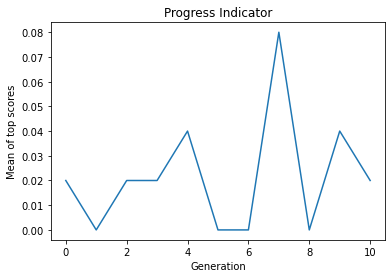

Gen:  11 
High Scores:  0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  4.1/ 4.1/ 3.5/ 2.3/ 0.3/ 1.5/ 2.5/ 1.5/ 0.12/ 2.8 
-----------
Gen:  12 
High Scores:  0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  4.2/ 4.2/ 3.6/ 2.4/ 0.4/ 1.6/ 2.6/ 1.6/ 0.13/ 2.9 
-----------
Gen:  13 
High Scores:  0.2/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  2.7/ 5.1/ 3.1/ 3.1/ 4.3/ 4.3/ 3.7/ 2.5/ 0.5/ 1.7 
-----------
Gen:  14 
High Scores:  0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  2.8/ 5.2/ 3.2/ 3.2/ 4.4/ 4.4/ 3.8/ 2.6/ 0.6/ 1.8 
-----------
Gen:  15 
High Scores:  0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  2.9/ 5.3/ 3.3/ 3.3/ 4.5/ 4.5/ 3.9/ 2.7/ 0.7/ 1.9 
-----------
Gen:  16 
High Scores:  0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  4.1/ 2.10/ 5.4/ 3.4/ 3.4/ 4.6/ 4.6/ 3.10/ 2.8/ 0.8 
-----------
Gen:  17 
High Scores:  0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  4.1/ 4.2/ 2.11/ 5.5/ 3.5/ 3.5

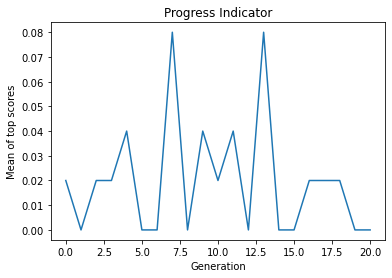

Gen:  21 
High Scores:  0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  3.15/ 4.5/ 4.6/ 2.15/ 5.9/ 3.9/ 3.9/ 4.11/ 4.11/ 2.13 
-----------
Gen:  22 
High Scores:  0.4/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  5.1/ 0.1/ 3.16/ 4.6/ 4.7/ 2.16/ 5.10/ 3.10/ 3.10/ 4.12 
-----------
Gen:  23 
High Scores:  0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  5.1/ 5.2/ 0.2/ 3.17/ 4.7/ 4.8/ 2.17/ 5.11/ 3.11/ 3.11 
-----------
Gen:  24 
High Scores:  0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  5.2/ 5.3/ 0.3/ 3.18/ 4.8/ 4.9/ 2.18/ 5.12/ 3.12/ 3.12 
-----------
Gen:  25 
High Scores:  0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  5.3/ 5.4/ 0.4/ 3.19/ 4.9/ 4.10/ 2.19/ 5.13/ 3.13/ 3.13 
-----------
Gen:  26 
High Scores:  0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  0.18/ 5.4/ 5.5/ 0.5/ 3.20/ 4.10/ 4.11/ 2.20/ 5.14/ 3.14 
-----------
Gen:  27 
High Scores:  0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes: 

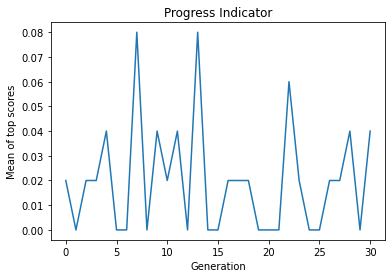

Gen:  31 
High Scores:  0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  5.1/ 5.1/ 4.16/ 5.10/ 2.25/ 0.5/ 0.23/ 5.9/ 0.10/ 3.25 
-----------
Gen:  32 
High Scores:  0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  3.1/ 5.2/ 5.2/ 4.17/ 5.11/ 2.26/ 0.6/ 0.24/ 5.10/ 0.11 
-----------
Gen:  33 
High Scores:  0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  0.7/ 5.1/ 0.1/ 3.2/ 5.3/ 5.3/ 4.18/ 5.12/ 2.27/ 0.25 
-----------
Gen:  34 
High Scores:  0.4/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  6.1/ 4.19/ 5.13/ 0.8/ 5.2/ 0.2/ 3.3/ 5.4/ 5.4/ 2.28 
-----------
Gen:  35 
High Scores:  0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  5.13/ 7.1/ 6.2/ 4.20/ 5.14/ 0.9/ 5.3/ 0.3/ 3.4/ 5.5 
-----------
Gen:  36 
High Scores:  0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  0.4/ 0.28/ 5.14/ 7.2/ 6.3/ 4.21/ 5.15/ 0.10/ 5.4/ 3.5 
-----------
Gen:  37 
High Scores:  0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  4.1/ 0

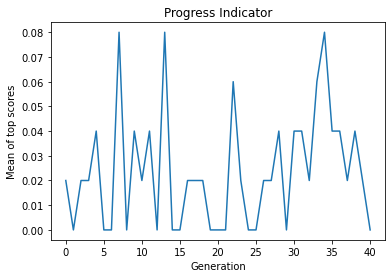

Gen:  41 
High Scores:  0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  5.20/ 3.29/ 6.4/ 4.5/ 0.9/ 0.33/ 5.19/ 7.7/ 6.8/ 4.26 
-----------
Gen:  42 
High Scores:  0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  5.21/ 3.30/ 6.5/ 4.6/ 0.10/ 0.34/ 5.20/ 7.8/ 6.9/ 4.27 
-----------
Gen:  43 
High Scores:  0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  5.22/ 3.31/ 6.6/ 4.7/ 0.11/ 0.35/ 5.21/ 7.9/ 6.10/ 4.28 
-----------
Gen:  44 
High Scores:  0.2/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  6.7/ 4.8/ 4.29/ 5.1/ 5.23/ 3.32/ 0.12/ 0.36/ 5.22/ 7.10 
-----------
Gen:  45 
High Scores:  0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  6.8/ 4.9/ 4.30/ 5.2/ 5.24/ 3.33/ 0.13/ 0.37/ 5.23/ 7.11 
-----------
Gen:  46 
High Scores:  0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  4.31/ 7.1/ 5.1/ 6.9/ 4.10/ 5.3/ 5.25/ 3.34/ 0.14/ 0.38 
-----------
Gen:  47 
High Scores:  0.2/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetim

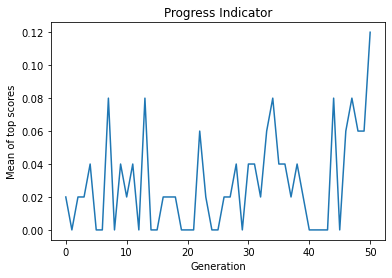

Gen:  51 
High Scores:  0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  8.1/ 5.30/ 7.17/ 7.2/ 6.2/ 6.2/ 0.2/ 6.14/ 0.19/ 8.3 
-----------
Gen:  52 
High Scores:  0.4/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  7.1/ 8.2/ 5.31/ 7.18/ 7.3/ 6.3/ 6.3/ 0.3/ 6.15/ 0.20 
-----------
Gen:  53 
High Scores:  0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0
Lifetimes:  4.38/ 5.8/ 8.1/ 7.1/ 8.1/ 8.1/ 9.1/ 7.1/ 7.2/ 8.3 
-----------
Gen:  54 
High Scores:  0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  10.1/ 4.39/ 5.9/ 8.2/ 7.2/ 8.2/ 8.2/ 9.2/ 7.2/ 7.3 
-----------
Gen:  55 
High Scores:  0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  7.6/ 6.18/ 10.1/ 10.2/ 4.40/ 5.10/ 8.3/ 7.3/ 8.3/ 8.3 
-----------
Gen:  56 
High Scores:  0.2/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  8.4/ 7.22/ 11.1/ 7.1/ 7.7/ 6.19/ 10.2/ 10.3/ 4.41/ 5.11 
-----------
Gen:  57 
High Scores:  0.2/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  11.1/ 9.1/

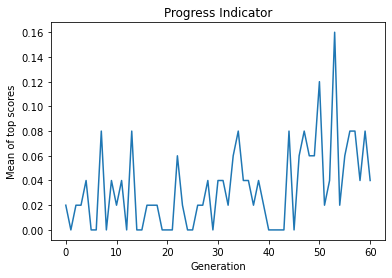

Gen:  61 
High Scores:  0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  10.2/ 12.1/ 10.1/ 10.1/ 10.1/ 9.5/ 4.46/ 8.9/ 11.3/ 8.9 
-----------
Gen:  62 
High Scores:  0.4/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  11.7/ 4.47/ 12.1/ 10.3/ 12.2/ 10.2/ 10.2/ 10.2/ 9.6/ 8.10 
-----------
Gen:  63 
High Scores:  0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  9.7/ 12.1/ 5.1/ 11.8/ 4.48/ 12.2/ 10.4/ 12.3/ 10.3/ 10.3 
-----------
Gen:  64 
High Scores:  0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  10.4/ 10.1/ 4.49/ 11.1/ 10.1/ 10.1/ 12.1/ 10.1/ 0.1/ 0.1 
-----------
Gen:  65 
High Scores:  0.4/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  10.5/ 10.5/ 10.2/ 4.50/ 11.2/ 10.2/ 10.2/ 12.2/ 10.2/ 0.2 
-----------
Gen:  66 
High Scores:  0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  10.3/ 11.1/ 11.1/ 11.1/ 11.1/ 10.6/ 10.6/ 10.3/ 4.51/ 11.3 
-----------
Gen:  67 
High Scores:  0.2/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0

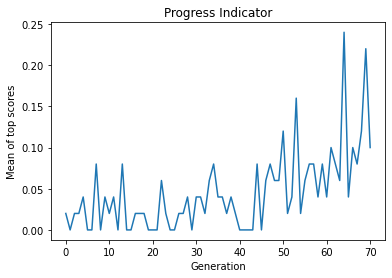

Gen:  71 
High Scores:  0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.0
Lifetimes:  12.1/ 10.2/ 10.8/ 9.15/ 10.8/ 11.1/ 12.1/ 11.1/ 12.1/ 11.4 
-----------
Gen:  72 
High Scores:  0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0
Lifetimes:  11.1/ 10.3/ 11.5/ 11.3/ 11.1/ 13.1/ 10.1/ 12.1/ 12.2/ 10.9 
-----------
Gen:  73 
High Scores:  0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0
Lifetimes:  11.2/ 12.3/ 12.1/ 12.1/ 12.1/ 12.1/ 12.1/ 10.4/ 11.6/ 11.4 
-----------
Gen:  74 
High Scores:  0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  11.4/ 13.1/ 11.3/ 12.2/ 12.2/ 12.2/ 10.5/ 12.4/ 13.1/ 13.1 
-----------
Gen:  75 
High Scores:  1.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  13.2/ 14.1/ 13.1/ 14.1/ 13.1/ 14.1/ 11.5/ 13.2/ 11.4/ 12.3 
-----------
Gen:  76 
High Scores:  0.8/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  14.1/ 13.3/ 15.1/ 12.4/ 12.4/ 12.6/ 13.3/ 14.1/ 14.1/ 14.1 
-----------
Gen:  77 
High Scores:  0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/

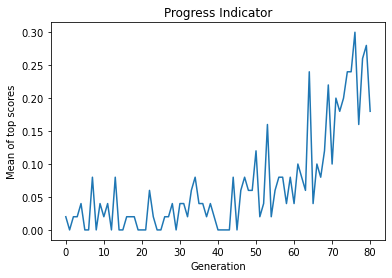

Gen:  81 
High Scores:  0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.0
Lifetimes:  13.8/ 16.2/ 15.3/ 17.2/ 14.4/ 18.1/ 16.1/ 16.1/ 15.1/ 13.8 
-----------
Gen:  82 
High Scores:  0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  17.1/ 16.1/ 15.4/ 14.5/ 16.4/ 15.4/ 14.7/ 17.1/ 16.1/ 15.1 
-----------
Gen:  83 
High Scores:  0.8/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  15.3/ 16.2/ 14.8/ 17.1/ 16.1/ 17.1/ 16.5/ 13.10/ 17.1/ 17.1 
-----------
Gen:  84 
High Scores:  0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  18.1/ 17.2/ 13.11/ 17.2/ 17.2/ 18.1/ 16.1/ 18.1/ 18.1/ 18.1 
-----------
Gen:  85 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  16.7/ 18.2/ 17.2/ 18.1/ 17.1/ 13.12/ 17.3/ 15.5/ 16.4/ 14.10 
-----------
Gen:  86 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  18.3/ 13.13/ 18.1/ 19.1/ 17.3/ 17.2/ 15.6/ 19.2/ 17.4/ 18.3 
-----------
Gen:  87 
High Scores:  0.6/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/

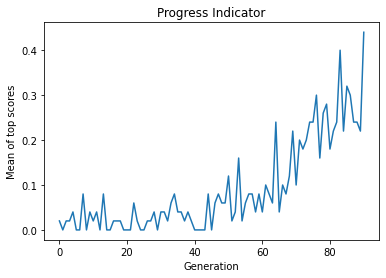

Gen:  91 
High Scores:  0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  13.18/ 24.1/ 20.2/ 17.8/ 20.4/ 18.4/ 22.2/ 23.2/ 21.2/ 21.1 
-----------
Gen:  92 
High Scores:  0.6/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  17.9/ 25.1/ 20.3/ 24.2/ 23.3/ 19.7/ 22.4/ 22.1/ 24.1/ 19.1 
-----------
Gen:  93 
High Scores:  0.6/ 0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  17.10/ 26.1/ 22.2/ 18.1/ 25.2/ 20.4/ 24.3/ 19.2/ 13.20/ 24.3 
-----------
Gen:  94 
High Scores:  0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  22.3/ 24.4/ 26.2/ 23.5/ 26.1/ 26.1/ 27.1/ 26.1/ 27.1/ 27.1 
-----------
Gen:  95 
High Scores:  0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  27.1/ 26.1/ 22.4/ 18.3/ 24.1/ 24.5/ 27.2/ 25.4/ 25.1/ 25.1 
-----------
Gen:  96 
High Scores:  0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  27.2/ 27.3/ 25.2/ 26.2/ 26.3/ 26.3/ 27.3/ 17.13/ 27.1/ 27.1 
-----------
Gen:  97 
High Scores:  0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 

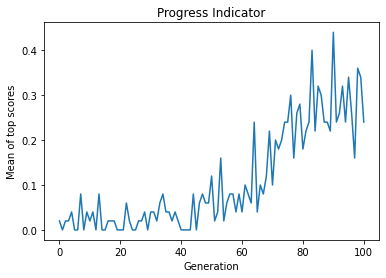

Gen:  101 
High Scores:  0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  29.1/ 28.4/ 26.8/ 29.2/ 30.2/ 30.2/ 17.18/ 29.3/ 29.3/ 27.8 
-----------
Gen:  102 
High Scores:  0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.0
Lifetimes:  31.1/ 30.1/ 29.3/ 31.2/ 30.2/ 32.1/ 31.1/ 30.1/ 30.1/ 29.2 
-----------
Gen:  103 
High Scores:  0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  29.5/ 30.2/ 32.1/ 26.10/ 30.4/ 29.5/ 28.3/ 32.1/ 32.1/ 31.1 
-----------
Gen:  104 
High Scores:  0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  28.4/ 31.2/ 30.4/ 31.3/ 28.7/ 31.1/ 33.1/ 30.1/ 29.1/ 31.1 
-----------
Gen:  105 
High Scores:  0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  32.1/ 26.12/ 34.1/ 33.1/ 33.1/ 31.1/ 28.5/ 31.3/ 30.5/ 31.4 
-----------
Gen:  106 
High Scores:  0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0
Lifetimes:  31.3/ 26.13/ 33.2/ 33.2/ 28.9/ 33.1/ 34.1/ 33.1/ 32.2/ 34.2 
-----------
Gen:  107 
High Scores:  0.8/ 0.4/ 0.2/ 0.2/ 0.2

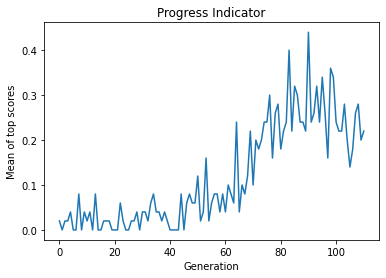

Gen:  111 
High Scores:  0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  29.3/ 35.1/ 31.9/ 33.3/ 28.14/ 34.5/ 35.1/ 36.1/ 35.1/ 35.1 
-----------
Gen:  112 
High Scores:  0.4/ 0.2/ 0.2/ 0.2/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0/ 0.0
Lifetimes:  31.8/ 35.2/ 30.1/ 0.1/ 29.4/ 31.10/ 33.4/ 28.15/ 34.6/ 35.2 
-----------
Gen:  113 
High Scores:  0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  34.1/ 31.9/ 26.20/ 36.1/ 36.1/ 36.1/ 36.1/ 38.1/ 36.1/ 37.1 
-----------
Gen:  114 
High Scores:  0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  32.1/ 36.2/ 32.1/ 31.10/ 36.2/ 30.3/ 0.3/ 37.1/ 35.1/ 37.1 
-----------
Gen:  115 
High Scores:  1.0/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2
Lifetimes:  37.1/ 32.2/ 38.1/ 37.1/ 36.1/ 33.1/ 37.1/ 36.3/ 32.2/ 34.3 
-----------
Gen:  116 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  38.2/ 33.2/ 39.1/ 35.1/ 38.1/ 34.4/ 38.2/ 37.2/ 33.2/ 37.2 
-----------
Gen:  117 
High Scores:  0.6/ 0.4/ 0.4/ 0.2/ 0.2/

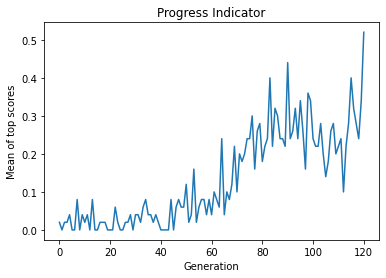

Gen:  121 
High Scores:  1.2/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  40.2/ 43.1/ 41.1/ 42.2/ 40.3/ 41.1/ 37.7/ 33.7/ 38.2/ 42.2 
-----------
Gen:  122 
High Scores:  0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  44.1/ 42.1/ 43.1/ 40.3/ 39.1/ 44.1/ 41.2/ 33.8/ 42.3/ 40.3 
-----------
Gen:  123 
High Scores:  0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  44.2/ 37.9/ 41.1/ 43.1/ 41.3/ 33.9/ 40.4/ 40.4/ 43.3/ 41.1 
-----------
Gen:  124 
High Scores:  0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2
Lifetimes:  41.2/ 42.1/ 42.1/ 41.4/ 41.2/ 44.3/ 42.1/ 37.10/ 45.2/ 44.1 
-----------
Gen:  125 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  42.1/ 42.2/ 40.6/ 46.1/ 41.3/ 37.11/ 40.6/ 45.1/ 43.1/ 0.1 
-----------
Gen:  126 
High Scores:  0.8/ 0.6/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  37.12/ 42.1/ 41.6/ 47.1/ 46.1/ 46.2/ 43.2/ 44.3/ 45.3/ 43.1 
-----------
Gen:  127 
High Scores:  0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 

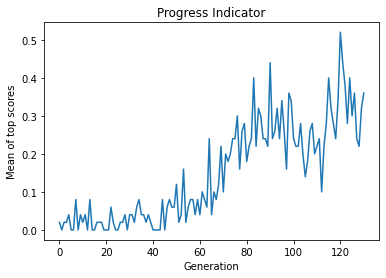

Gen:  131 
High Scores:  0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  46.6/ 50.1/ 49.1/ 51.1/ 49.1/ 48.2/ 49.3/ 42.6/ 49.1/ 44.1 
-----------
Gen:  132 
High Scores:  0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2
Lifetimes:  49.2/ 49.4/ 49.4/ 51.2/ 48.3/ 45.2/ 47.1/ 51.1/ 46.7/ 44.4 
-----------
Gen:  133 
High Scores:  0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2
Lifetimes:  50.2/ 49.1/ 49.5/ 51.2/ 44.5/ 52.1/ 52.1/ 52.1/ 49.3/ 48.4 
-----------
Gen:  134 
High Scores:  0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  51.3/ 45.4/ 52.1/ 49.2/ 49.6/ 44.6/ 49.4/ 50.2/ 53.1/ 53.1 
-----------
Gen:  135 
High Scores:  0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  52.2/ 52.3/ 54.1/ 51.4/ 49.3/ 44.7/ 50.3/ 53.2/ 53.2/ 48.6 
-----------
Gen:  136 
High Scores:  0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  50.4/ 54.2/ 54.1/ 54.1/ 54.2/ 49.4/ 44.8/ 53.3/ 51.2/ 45.6 
-----------
Gen:  137 
High Scores:  0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.

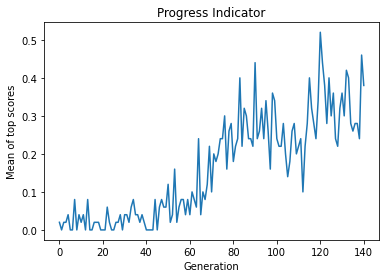

Gen:  141 
High Scores:  0.8/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  53.6/ 54.4/ 58.1/ 59.1/ 54.1/ 58.1/ 48.12/ 58.2/ 57.3/ 55.3 
-----------
Gen:  142 
High Scores:  1.0/ 1.0/ 0.8/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  58.3/ 59.1/ 59.2/ 53.7/ 59.2/ 57.1/ 54.2/ 58.2/ 56.3/ 59.1 
-----------
Gen:  143 
High Scores:  0.8/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  61.1/ 54.3/ 54.2/ 60.2/ 61.1/ 58.3/ 59.2/ 60.2/ 54.6/ 60.2 
-----------
Gen:  144 
High Scores:  1.0/ 0.8/ 0.6/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  60.3/ 60.1/ 54.4/ 54.7/ 59.2/ 59.4/ 54.3/ 58.4/ 59.3/ 60.3 
-----------
Gen:  145 
High Scores:  1.0/ 0.6/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  59.3/ 54.8/ 60.4/ 59.4/ 62.2/ 62.2/ 63.1/ 61.1/ 61.1/ 63.1 
-----------
Gen:  146 
High Scores:  0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  61.1/ 59.4/ 61.2/ 61.2/ 60.3/ 54.6/ 58.6/ 61.1/ 61.1/ 60.1 
-----------
Gen:  147 
High Scores:  1.0/ 0.8/ 0.6/ 0.4/ 0.4/ 0

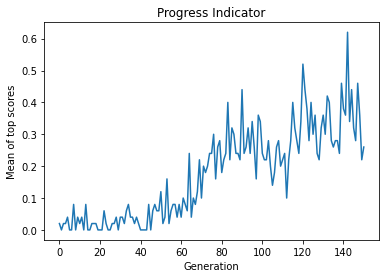

Gen:  151 
High Scores:  0.6/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  60.8/ 62.5/ 63.3/ 63.4/ 61.4/ 61.2/ 63.2/ 55.4/ 58.11/ 64.1 
-----------
Gen:  152 
High Scores:  0.6/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  63.3/ 60.9/ 62.6/ 63.4/ 61.3/ 58.12/ 62.2/ 65.2/ 64.2/ 62.1 
-----------
Gen:  153 
High Scores:  0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  62.1/ 60.10/ 64.1/ 63.5/ 61.4/ 62.1/ 64.1/ 65.1/ 62.1/ 62.1 
-----------
Gen:  154 
High Scores:  1.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  61.1/ 62.2/ 62.2/ 62.2/ 63.7/ 63.1/ 65.1/ 63.1/ 65.1/ 65.1 
-----------
Gen:  155 
High Scores:  0.8/ 0.8/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2
Lifetimes:  64.3/ 62.1/ 63.1/ 64.1/ 63.1/ 63.1/ 63.1/ 63.1/ 61.2/ 62.3 
-----------
Gen:  156 
High Scores:  0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  63.2/ 62.4/ 64.2/ 63.2/ 63.2/ 61.3/ 60.13/ 64.1/ 65.1/ 67.1 
-----------
Gen:  157 
High Scores:  0.4/ 0.2/ 0.2/ 0.2/ 0.2

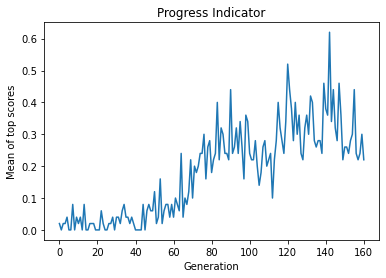

Gen:  161 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  68.1/ 60.18/ 64.4/ 68.3/ 65.1/ 66.1/ 65.4/ 65.1/ 64.1/ 66.1 
-----------
Gen:  162 
High Scores:  0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  69.1/ 66.2/ 66.2/ 68.2/ 66.2/ 68.2/ 69.1/ 65.1/ 69.1/ 66.1 
-----------
Gen:  163 
High Scores:  0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  69.2/ 69.1/ 70.1/ 60.20/ 69.1/ 66.3/ 64.3/ 69.1/ 70.1/ 70.1 
-----------
Gen:  164 
High Scores:  0.8/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  66.4/ 69.2/ 60.21/ 69.2/ 67.2/ 70.2/ 69.3/ 66.4/ 68.4/ 71.1 
-----------
Gen:  165 
High Scores:  0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2
Lifetimes:  60.22/ 69.4/ 71.1/ 65.2/ 70.1/ 72.1/ 70.1/ 72.1/ 69.3/ 68.5 
-----------
Gen:  166 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  73.1/ 68.6/ 70.4/ 69.2/ 73.1/ 60.23/ 71.2/ 70.2/ 70.2/ 70.2 
-----------
Gen:  167 
High Scores:  0.6/ 0.2/ 0.2/ 0.2/ 0.

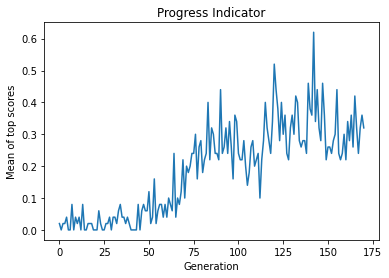

Gen:  171 
High Scores:  0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  69.10/ 76.1/ 70.2/ 73.2/ 72.2/ 71.4/ 71.2/ 76.2/ 72.2/ 73.1 
-----------
Gen:  172 
High Scores:  0.6/ 0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  73.3/ 74.1/ 74.1/ 71.1/ 70.3/ 72.3/ 76.2/ 74.6/ 74.1/ 77.1 
-----------
Gen:  173 
High Scores:  0.8/ 0.8/ 0.6/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  70.4/ 74.1/ 71.2/ 74.2/ 76.3/ 74.7/ 72.2/ 76.3/ 72.4/ 71.6 
-----------
Gen:  174 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  75.1/ 74.2/ 78.2/ 76.1/ 73.1/ 70.5/ 76.4/ 72.3/ 75.2/ 75.2 
-----------
Gen:  175 
High Scores:  0.8/ 0.6/ 0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  73.1/ 73.2/ 76.1/ 76.2/ 77.1/ 78.3/ 78.2/ 71.4/ 73.1/ 77.1 
-----------
Gen:  176 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  78.1/ 73.2/ 78.1/ 78.1/ 76.2/ 78.4/ 77.2/ 76.2/ 73.3/ 70.7 
-----------
Gen:  177 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0

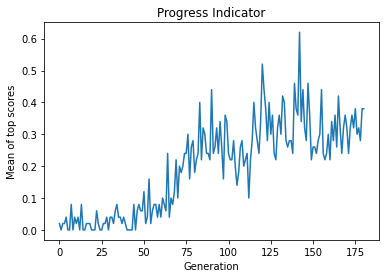

Gen:  181 
High Scores:  0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2
Lifetimes:  79.5/ 81.2/ 81.1/ 78.4/ 78.5/ 78.6/ 81.1/ 81.1/ 80.2/ 80.4 
-----------
Gen:  182 
High Scores:  0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  78.5/ 78.6/ 81.2/ 81.2/ 79.1/ 79.6/ 80.5/ 79.2/ 81.2/ 82.1 
-----------
Gen:  183 
High Scores:  0.8/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  81.1/ 79.3/ 78.8/ 80.1/ 82.1/ 78.6/ 81.3/ 81.3/ 82.1/ 82.1 
-----------
Gen:  184 
High Scores:  0.6/ 0.6/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  83.1/ 82.1/ 82.1/ 79.4/ 80.2/ 78.7/ 78.8/ 79.8/ 83.1/ 82.1 
-----------
Gen:  185 
High Scores:  1.0/ 1.0/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2
Lifetimes:  83.2/ 84.1/ 84.1/ 79.2/ 78.10/ 83.1/ 83.1/ 82.2/ 80.3/ 79.9 
-----------
Gen:  186 
High Scores:  1.0/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  83.2/ 80.4/ 85.1/ 83.3/ 84.2/ 79.3/ 78.11/ 79.10/ 84.2/ 84.2 
-----------
Gen:  187 
High Scores:  1.0/ 0.8/ 0.6/ 0.4/ 0.4/

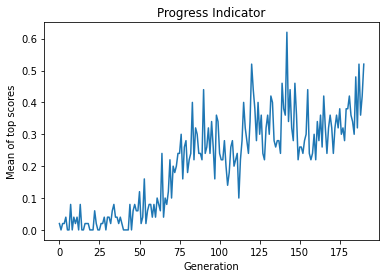

Gen:  191 
High Scores:  0.8/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  87.2/ 86.3/ 86.3/ 81.3/ 88.1/ 88.1/ 86.2/ 87.2/ 78.16/ 85.5 
-----------
Gen:  192 
High Scores:  0.8/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2
Lifetimes:  86.3/ 89.1/ 89.1/ 87.3/ 79.9/ 87.2/ 87.1/ 87.3/ 81.4/ 88.2 
-----------
Gen:  193 
High Scores:  1.0/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  90.1/ 87.4/ 88.3/ 89.1/ 89.1/ 89.1/ 82.1/ 88.1/ 90.1/ 88.1 
-----------
Gen:  194 
High Scores:  0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  88.2/ 79.11/ 81.6/ 91.1/ 89.2/ 91.1/ 89.2/ 90.2/ 87.5/ 88.2 
-----------
Gen:  195 
High Scores:  0.6/ 0.6/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.0
Lifetimes:  79.12/ 91.1/ 90.3/ 91.2/ 90.3/ 87.6/ 92.1/ 82.1/ 89.1/ 88.3 
-----------
Gen:  196 
High Scores:  0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  87.7/ 88.4/ 88.3/ 89.3/ 79.13/ 90.4/ 92.2/ 89.4/ 89.4/ 91.1 
-----------
Gen:  197 
High Scores:  0.8/ 0.6/ 0.6/ 0.6/ 0.4

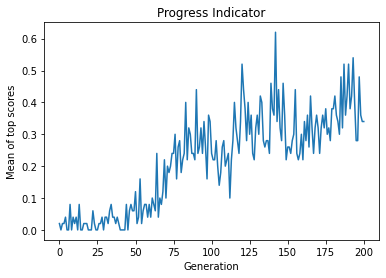

Gen:  201 
High Scores:  0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  91.5/ 79.18/ 93.4/ 94.3/ 94.2/ 94.2/ 94.2/ 93.2/ 91.5/ 94.1 
-----------
Gen:  202 
High Scores:  0.8/ 0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  92.2/ 95.1/ 94.3/ 92.1/ 91.6/ 93.5/ 94.3/ 89.10/ 93.6/ 95.1 
-----------
Gen:  203 
High Scores:  0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  91.7/ 94.4/ 95.1/ 94.1/ 94.4/ 93.6/ 89.11/ 93.7/ 95.2/ 79.20 
-----------
Gen:  204 
High Scores:  0.6/ 0.6/ 0.6/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  91.8/ 96.1/ 95.1/ 94.1/ 94.5/ 95.2/ 94.5/ 93.8/ 79.21/ 95.2 
-----------
Gen:  205 
High Scores:  0.8/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2
Lifetimes:  94.3/ 94.6/ 79.22/ 92.5/ 95.3/ 96.1/ 96.1/ 96.1/ 91.9/ 95.2 
-----------
Gen:  206 
High Scores:  0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2
Lifetimes:  96.2/ 95.1/ 94.7/ 92.6/ 89.14/ 94.1/ 93.1/ 95.4/ 91.10/ 92.2 
-----------
Gen:  207 
High Scores:  0.8/ 0.4/ 0.4/ 0.4/

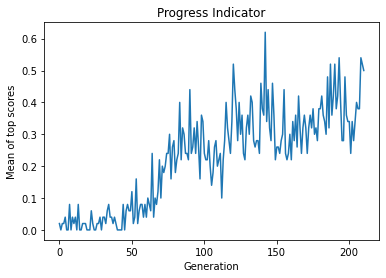

Gen:  211 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2
Lifetimes:  94.4/ 91.15/ 100.2/ 100.2/ 94.12/ 92.1/ 101.1/ 97.6/ 92.11/ 100.2 
-----------
Gen:  212 
High Scores:  1.0/ 1.0/ 0.8/ 0.8/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  100.3/ 100.3/ 97.7/ 92.12/ 94.5/ 94.13/ 96.2/ 98.1/ 101.1/ 101.1 
-----------
Gen:  213 
High Scores:  0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2
Lifetimes:  97.8/ 96.1/ 100.4/ 94.14/ 98.1/ 102.1/ 103.1/ 100.4/ 92.13/ 94.6 
-----------
Gen:  214 
High Scores:  0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2
Lifetimes:  100.5/ 101.1/ 102.1/ 100.5/ 94.15/ 103.2/ 98.3/ 101.1/ 102.1/ 97.9 
-----------
Gen:  215 
High Scores:  1.2/ 0.8/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  102.3/ 97.10/ 98.4/ 100.6/ 94.16/ 101.2/ 104.1/ 103.1/ 105.1/ 103.1 
-----------
Gen:  216 
High Scores:  0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  99.2/ 102.1/ 101.1/ 102.4/ 97.11/ 98.5/ 100.7/ 97.3/ 103.2/ 104.1 
-----------
Gen:  217

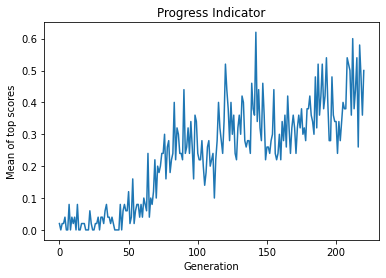

Gen:  221 
High Scores:  0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  100.3/ 105.1/ 97.16/ 101.4/ 104.2/ 105.2/ 102.9/ 103.3/ 105.1/ 105.1 
-----------
Gen:  222 
High Scores:  0.8/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2
Lifetimes:  104.7/ 104.3/ 101.5/ 102.10/ 101.1/ 106.1/ 106.1/ 105.2/ 97.17/ 105.2 
-----------
Gen:  223 
High Scores:  0.8/ 0.6/ 0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  106.1/ 105.2/ 107.1/ 106.2/ 106.1/ 104.8/ 104.4/ 101.6/ 106.2/ 105.3 
-----------
Gen:  224 
High Scores:  1.2/ 0.8/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  106.1/ 104.5/ 104.9/ 106.2/ 106.2/ 101.7/ 105.4/ 105.8/ 103.3/ 105.3 
-----------
Gen:  225 
High Scores:  1.0/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  108.1/ 106.2/ 104.6/ 101.8/ 106.1/ 108.1/ 105.5/ 103.4/ 107.2/ 107.2 
-----------
Gen:  226 
High Scores:  0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2
Lifetimes:  105.3/ 109.1/ 105.2/ 104.1/ 107.1/ 110.1/ 110.1/ 101.9/ 106.2/ 107.3 
---

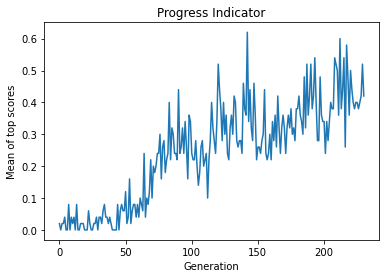

Gen:  231 
High Scores:  0.8/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2
Lifetimes:  113.2/ 114.1/ 113.1/ 113.2/ 112.1/ 114.1/ 111.1/ 111.1/ 110.5/ 113.2 
-----------
Gen:  232 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2
Lifetimes:  113.2/ 113.2/ 113.3/ 112.2/ 110.6/ 114.1/ 114.1/ 114.1/ 113.3/ 114.2 
-----------
Gen:  233 
High Scores:  1.0/ 0.8/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  113.3/ 115.1/ 112.3/ 114.3/ 115.1/ 115.1/ 113.3/ 110.7/ 114.2/ 113.4 
-----------
Gen:  234 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  114.3/ 114.2/ 115.2/ 114.1/ 115.1/ 115.2/ 114.4/ 115.2/ 114.3/ 113.5 
-----------
Gen:  235 
High Scores:  0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  113.6/ 112.5/ 117.1/ 116.1/ 114.4/ 114.3/ 114.2/ 115.2/ 115.3/ 109.7 
-----------
Gen:  236 
High Scores:  1.2/ 0.8/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2
Lifetimes:  117.1/ 114.5/ 117.1/ 116.1/ 114.4/ 116.3/ 115.2/ 117.1/ 113.7/ 115.3 
----

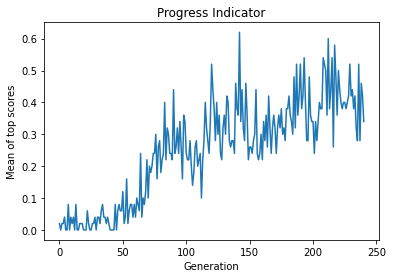

Gen:  241 
High Scores:  0.6/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  114.4/ 120.3/ 115.7/ 114.9/ 117.2/ 121.2/ 117.4/ 113.12/ 121.1/ 117.1 
-----------
Gen:  242 
High Scores:  0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  121.3/ 122.1/ 115.8/ 120.2/ 121.2/ 118.1/ 121.2/ 121.2/ 115.2/ 117.2 
-----------
Gen:  243 
High Scores:  0.8/ 0.8/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2
Lifetimes:  117.3/ 121.1/ 121.3/ 121.3/ 118.2/ 122.1/ 122.1/ 121.4/ 115.9/ 120.3 
-----------
Gen:  244 
High Scores:  0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  122.2/ 123.1/ 117.4/ 122.2/ 121.4/ 123.2/ 122.2/ 123.1/ 123.1/ 122.1 
-----------
Gen:  245 
High Scores:  0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2
Lifetimes:  122.3/ 122.1/ 123.2/ 117.5/ 123.2/ 123.1/ 123.1/ 122.3/ 121.5/ 123.3 
-----------
Gen:  246 
High Scores:  0.8/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  122.4/ 121.6/ 123.3/ 124.1/ 124.1/ 124.1/ 122.2/ 117.6/ 123.4/ 118.5 
---

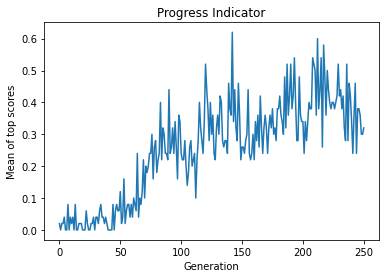

Gen:  251 
High Scores:  0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2
Lifetimes:  124.6/ 125.4/ 126.1/ 117.11/ 124.3/ 125.5/ 128.1/ 126.1/ 127.3/ 126.2 
-----------
Gen:  252 
High Scores:  0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  117.12/ 126.2/ 127.1/ 126.2/ 125.6/ 128.2/ 127.4/ 127.2/ 127.2/ 127.1 
-----------
Gen:  253 
High Scores:  0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  117.13/ 125.6/ 128.1/ 126.3/ 127.2/ 126.3/ 128.3/ 128.2/ 124.8/ 127.1 
-----------
Gen:  254 
High Scores:  0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  125.7/ 128.2/ 126.4/ 126.2/ 125.8/ 129.1/ 126.4/ 128.2/ 128.2/ 128.1 
-----------
Gen:  255 
High Scores:  1.6/ 0.8/ 0.8/ 0.6/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4
Lifetimes:  126.3/ 129.2/ 130.1/ 125.9/ 117.15/ 127.1/ 130.1/ 129.1/ 128.2/ 128.2 
-----------
Gen:  256 
High Scores:  0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  126.6/ 129.2/ 131.1/ 127.1/ 125.10/ 129.2/ 125.9/ 126.6/ 128.3/ 127.2 

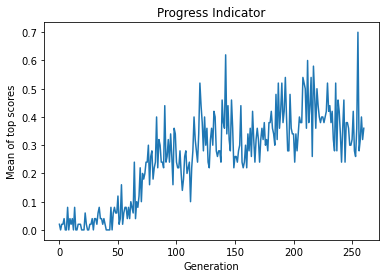

Gen:  261 
High Scores:  0.6/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  125.14/ 117.21/ 131.2/ 128.1/ 132.1/ 126.11/ 134.2/ 132.4/ 133.1/ 132.1 
-----------
Gen:  262 
High Scores:  1.4/ 1.0/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2
Lifetimes:  133.4/ 127.1/ 132.2/ 125.15/ 126.12/ 133.1/ 129.1/ 132.1/ 134.1/ 128.2 
-----------
Gen:  263 
High Scores:  0.8/ 0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  128.3/ 134.1/ 129.2/ 134.1/ 133.5/ 132.3/ 126.13/ 134.4/ 130.9/ 132.2 
-----------
Gen:  264 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  132.4/ 126.14/ 130.10/ 134.1/ 134.1/ 128.4/ 133.6/ 133.3/ 135.3/ 135.2 
-----------
Gen:  265 
High Scores:  0.6/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  130.11/ 126.15/ 128.5/ 135.4/ 134.3/ 135.2/ 133.2/ 137.2/ 135.2/ 134.1 
-----------
Gen:  266 
High Scores:  0.6/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  137.1/ 135.3/ 130.12/ 128.6/ 135.3/ 136.2/ 136.2/ 131.2/ 136.1/ 

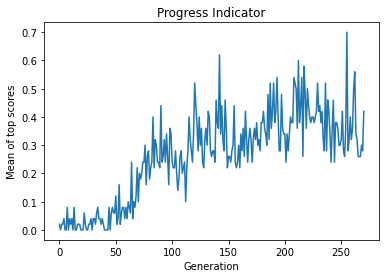

Gen:  271 
High Scores:  0.8/ 0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  136.4/ 130.17/ 134.9/ 139.1/ 136.3/ 137.6/ 131.7/ 140.1/ 139.1/ 137.1 
-----------
Gen:  272 
High Scores:  1.0/ 0.6/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  136.4/ 139.2/ 137.1/ 141.1/ 130.18/ 139.2/ 137.7/ 131.8/ 140.2/ 138.6 
-----------
Gen:  273 
High Scores:  0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  137.2/ 130.19/ 132.2/ 142.1/ 142.1/ 138.1/ 139.3/ 131.9/ 140.4/ 140.2 
-----------
Gen:  274 
High Scores:  1.0/ 0.6/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  131.10/ 137.2/ 132.3/ 143.1/ 140.1/ 137.3/ 130.20/ 140.3/ 142.2/ 140.2 
-----------
Gen:  275 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  140.3/ 132.4/ 138.2/ 138.1/ 137.1/ 143.1/ 143.2/ 130.21/ 136.7/ 140.2 
-----------
Gen:  276 
High Scores:  0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2
Lifetimes:  133.2/ 132.2/ 137.2/ 141.1/ 142.1/ 144.1/ 141.1/ 140.4/ 137.2/ 143.3

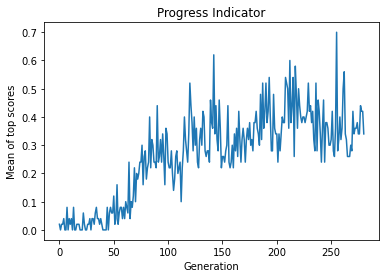

Gen:  281 
High Scores:  0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2
Lifetimes:  146.3/ 147.2/ 148.1/ 144.6/ 136.13/ 146.3/ 145.2/ 148.2/ 147.1/ 147.2 
-----------
Gen:  282 
High Scores:  0.8/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  145.3/ 144.7/ 146.4/ 149.1/ 148.1/ 146.4/ 136.14/ 148.3/ 147.4/ 145.3 
-----------
Gen:  283 
High Scores:  0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  136.15/ 149.2/ 149.1/ 145.4/ 146.5/ 146.5/ 148.4/ 145.4/ 148.3/ 137.2 
-----------
Gen:  284 
High Scores:  1.2/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2
Lifetimes:  150.1/ 136.16/ 149.1/ 149.1/ 150.2/ 150.2/ 144.9/ 149.1/ 146.1/ 145.5 
-----------
Gen:  285 
High Scores:  0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2
Lifetimes:  144.10/ 145.2/ 151.1/ 149.2/ 149.4/ 149.3/ 150.1/ 150.2/ 145.6/ 148.5 
-----------
Gen:  286 
High Scores:  0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2
Lifetimes:  147.1/ 144.11/ 149.3/ 151.2/ 152.1/ 150.1/ 151.1/ 151.1/ 150.3/ 145.7

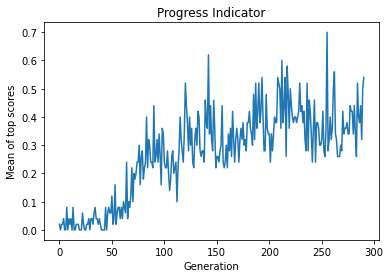

Gen:  291 
High Scores:  0.6/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  150.8/ 144.16/ 154.1/ 153.1/ 153.1/ 153.2/ 145.12/ 152.2/ 154.1/ 153.1 
-----------
Gen:  292 
High Scores:  1.2/ 1.0/ 0.8/ 0.8/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2
Lifetimes:  145.13/ 155.1/ 154.2/ 155.1/ 150.9/ 154.2/ 153.2/ 153.1/ 155.1/ 144.17 
-----------
Gen:  293 
High Scores:  1.2/ 0.8/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2/ 0.2/ 0.2/ 0.2
Lifetimes:  150.10/ 144.18/ 155.2/ 153.2/ 156.1/ 155.1/ 145.14/ 155.2/ 154.3/ 153.3 
-----------
Gen:  294 
High Scores:  1.2/ 1.0/ 0.8/ 0.8/ 0.6/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4
Lifetimes:  145.15/ 154.2/ 154.4/ 156.2/ 150.11/ 152.1/ 155.1/ 156.1/ 156.1/ 156.2 
-----------
Gen:  295 
High Scores:  1.2/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2
Lifetimes:  145.16/ 155.1/ 154.3/ 150.12/ 157.2/ 155.1/ 151.1/ 157.1/ 151.1/ 156.2 
-----------
Gen:  296 
High Scores:  1.2/ 1.0/ 0.8/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  158.1/ 150.13/ 156.1/ 156.3/ 157.2/ 157.1/ 155.2/ 151.2/ 151.2/

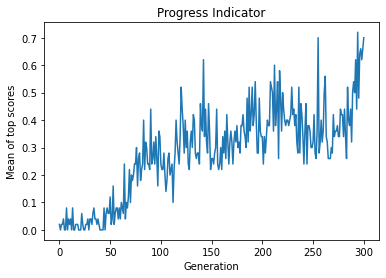

Gen:  301 
High Scores:  1.0/ 0.8/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  161.1/ 150.18/ 161.2/ 155.2/ 160.1/ 160.1/ 158.5/ 160.4/ 161.2/ 162.1 
-----------
Gen:  302 
High Scores:  0.8/ 0.6/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  160.3/ 159.2/ 145.23/ 161.3/ 163.1/ 162.1/ 150.19/ 158.6/ 162.2/ 162.2 
-----------
Gen:  303 
High Scores:  1.0/ 1.0/ 0.8/ 0.6/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4
Lifetimes:  150.20/ 163.1/ 163.2/ 145.24/ 162.3/ 161.3/ 161.1/ 159.1/ 158.7/ 162.2 
-----------
Gen:  304 
High Scores:  0.8/ 0.8/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  150.21/ 162.3/ 163.2/ 163.1/ 163.3/ 161.2/ 158.8/ 164.1/ 163.1/ 163.1 
-----------
Gen:  305 
High Scores:  0.8/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  165.1/ 162.4/ 163.3/ 165.1/ 150.22/ 163.2/ 161.6/ 162.4/ 163.1/ 162.1 
-----------
Gen:  306 
High Scores:  1.4/ 0.8/ 0.8/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4
Lifetimes:  164.1/ 161.4/ 163.2/ 163.3/ 162.5/ 164.2/ 166.1/ 162.2/ 166.1/ 164.

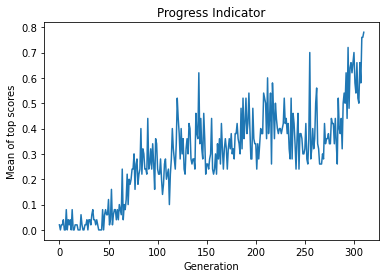

Gen:  311 
High Scores:  1.8/ 1.2/ 0.8/ 0.8/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4
Lifetimes:  164.6/ 150.28/ 165.2/ 165.1/ 164.3/ 166.1/ 164.1/ 168.1/ 165.2/ 165.1 
-----------
Gen:  312 
High Scores:  1.4/ 1.0/ 0.8/ 0.8/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4
Lifetimes:  165.1/ 165.1/ 168.2/ 169.1/ 166.2/ 166.2/ 164.5/ 166.1/ 164.7/ 150.29 
-----------
Gen:  313 
High Scores:  0.8/ 0.8/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  163.9/ 169.1/ 165.4/ 170.1/ 166.1/ 167.1/ 164.8/ 150.30/ 167.1/ 166.1 
-----------
Gen:  314 
High Scores:  1.2/ 1.0/ 1.0/ 1.0/ 1.0/ 1.0/ 0.8/ 0.8/ 0.6/ 0.6
Lifetimes:  150.31/ 163.10/ 169.2/ 168.4/ 166.1/ 171.1/ 167.2/ 164.9/ 166.2/ 164.7 
-----------
Gen:  315 
High Scores:  1.2/ 1.2/ 1.0/ 1.0/ 1.0/ 0.8/ 0.8/ 0.8/ 0.8/ 0.6
Lifetimes:  170.1/ 170.1/ 150.32/ 171.2/ 170.1/ 163.11/ 167.3/ 170.2/ 168.1/ 164.10 
-----------
Gen:  316 
High Scores:  1.0/ 1.0/ 1.0/ 0.8/ 0.8/ 0.8/ 0.6/ 0.6/ 0.6/ 0.6
Lifetimes:  166.4/ 170.1/ 171.1/ 170.2/ 170.2/ 165.2/ 170.2/ 171.3/ 166.3/ 169

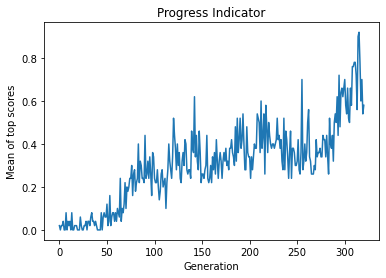

Gen:  321 
High Scores:  0.6/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  173.4/ 173.3/ 174.2/ 174.1/ 175.1/ 173.5/ 174.2/ 175.1/ 175.1/ 174.1 
-----------
Gen:  322 
High Scores:  1.2/ 1.2/ 0.8/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  174.2/ 170.8/ 173.4/ 174.3/ 176.1/ 173.6/ 174.3/ 174.2/ 173.4/ 174.3 
-----------
Gen:  323 
High Scores:  1.0/ 0.8/ 0.8/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  177.1/ 174.4/ 175.1/ 174.3/ 174.4/ 176.1/ 173.5/ 173.7/ 173.5/ 177.1 
-----------
Gen:  324 
High Scores:  1.4/ 1.0/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  174.5/ 175.1/ 178.1/ 174.4/ 173.6/ 173.6/ 175.2/ 174.5/ 165.10/ 175.1 
-----------
Gen:  325 
High Scores:  1.0/ 0.8/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  173.7/ 179.1/ 178.1/ 176.1/ 178.2/ 174.5/ 175.3/ 176.2/ 176.2/ 178.2 
-----------
Gen:  326 
High Scores:  0.8/ 0.8/ 0.8/ 0.6/ 0.6/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4
Lifetimes:  175.2/ 175.2/ 177.1/ 173.8/ 174.6/ 179.1/ 174.1/ 179.1/ 177.1/ 176.2 
---

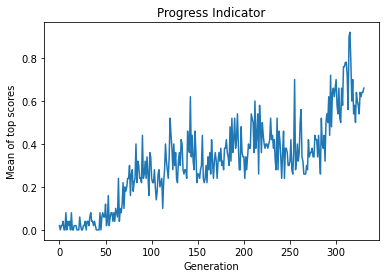

Gen:  331 
High Scores:  1.2/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.2
Lifetimes:  181.1/ 165.17/ 179.3/ 175.2/ 176.1/ 181.1/ 180.1/ 179.1/ 175.1/ 178.4 
-----------
Gen:  332 
High Scores:  1.0/ 0.8/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  181.2/ 165.18/ 177.1/ 181.1/ 181.1/ 181.2/ 179.4/ 179.2/ 178.5/ 174.12 
-----------
Gen:  333 
High Scores:  0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  181.3/ 180.4/ 181.1/ 181.1/ 165.19/ 174.13/ 182.2/ 180.2/ 179.5/ 180.2 
-----------
Gen:  334 
High Scores:  2.2/ 1.2/ 0.8/ 0.6/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4
Lifetimes:  166.1/ 180.3/ 180.4/ 181.4/ 182.1/ 182.1/ 182.1/ 181.2/ 181.2/ 184.1 
-----------
Gen:  335 
High Scores:  0.8/ 0.8/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  180.5/ 183.1/ 182.2/ 166.2/ 184.2/ 175.2/ 180.6/ 181.1/ 183.1/ 181.1 
-----------
Gen:  336 
High Scores:  1.2/ 0.8/ 0.8/ 0.6/ 0.6/ 0.6/ 0.4/ 0.4/ 0.4/ 0.4
Lifetimes:  175.3/ 183.1/ 185.1/ 183.2/ 184.1/ 182.1/ 182.3/ 166.3/ 184.3/ 180.7 

KeyboardInterrupt: 

In [7]:
pop2 = evolve(pop1,400,0.05,0.25,0.70,0.5,
              5,20,[1,1,0,1,0,0])

In [ ]:
# Load

popLoad = []
for i in range(80):
    newPlayer = player(shape=[64,2000,2000,4])
    if i <= 39:
        newPlayer.load(str(i)+".txt")
        print(i)
    popLoad.append(newPlayer)

In [ ]:
pop3 = evolve(pop1,200,0.04,0.8,8,5,10,[1,0,0,0,0,0])

In [ ]:
# Save

for i in range(10):
    pop2[i].save(str(i)+".txt")

## Test goodplayer

In [ ]:
goodplayer = pop1[1]

In [8]:
goodplayer = player()
goodplayer.load("0.txt")

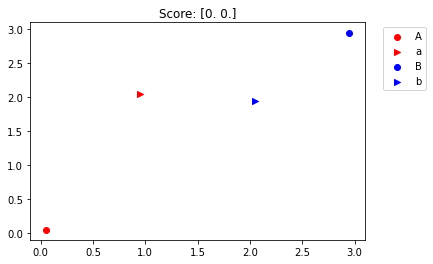

In [108]:
game1 = game(size=4,rules=[1,1,0,1,0,0])
game1.start()
game1.display()

In [ ]:
game1.move(2,2)
game1.display()

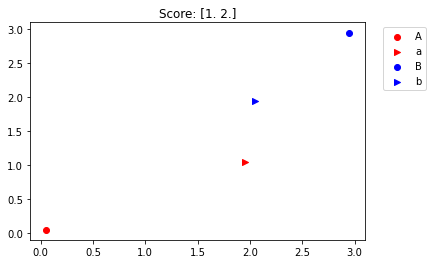

In [141]:
game1.move(np.argmax(goodplayer.compute(game1.output(True))),1)
game1.display()

In [140]:
goodplayer.compute(game1.output(False))

array([[4.16211169e-07],
       [3.12406576e-04],
       [3.99381511e-11],
       [1.14336016e-04]])